In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imutils
import os

In [8]:
# Paths to images
image_paths = ['input1/'+ i + '.jpeg' for i in ['left', 'center', 'right']]
print(image_paths)

['input1/left.jpeg', 'input1/center.jpeg', 'input1/right.jpeg']


In [9]:
# SIFT Detector
sift = cv2.SIFT_create()

# Store keypoints and descriptors
keypoints_list = []
descriptors_list = []
images = []

In [10]:
def detect_keypoints(image_path):
    image = cv2.imread(image_path) # Load image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert to grayscale
    keypoints, descriptors = sift.detectAndCompute(gray, None) # Detect keypoints and descriptors
    return image, keypoints, descriptors

def display_keypoints(images, keypoints_list, image_paths):
    fig, axes = plt.subplots(1, len(images), figsize=(15, 5)) # Create figure
    for ax, img, kps, path in zip(axes, images, keypoints_list, image_paths):  # Iterate over images
        img_with_keypoints = cv2.drawKeypoints(img, kps, None, color=(0, 255, 0), flags=0) # Draw keypoints
        ax.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB)) 
        ax.set_title(path.split('/')[-1])
        ax.axis("off")
    plt.show()

def stitch_images(image1, image2, keypoints1, keypoints2, descriptors1, descriptors2):
    # Match keypoints
    matcher = cv2.BFMatcher() # Create a matcher object
    matches = matcher.knnMatch(descriptors1, descriptors2, k=2) # Find the 2 nearest neighbors of each descriptor
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance] # Here 0.75 is a threshold. this is Lowe's ratio test
    matches = np.array([[keypoints1[m.queryIdx].pt + keypoints2[m.trainIdx].pt] for m in good_matches]).reshape(-1, 4)
    
    # Compute homography
    points1, points2 = matches[:, :2], matches[:, 2:] # Get points
    H, _ = cv2.findHomography(points2, points1, cv2.RANSAC) # Compute homography
    
    # Stitch images
    h1, w1 = image1.shape[:2] # Get shape of image1
    h2, w2 = image2.shape[:2]
    panorama = cv2.warpPerspective(image2, H, (w1 + w2, h1)) # Warp image2 to image1
    panorama[0:h1, 0:w1] = image1
    
    # Crop black areas more precisely
    # gray_panorama = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
    # _, thresh = cv2.threshold(gray_panorama, 1, 255, cv2.THRESH_BINARY)
    # coords = cv2.findNonZero(thresh)
    # x, y, w, h = cv2.boundingRect(coords)
    # panorama = panorama[y:y+h, x:x+w]=

    return panorama

def crop_tilted_black_seam(image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) # Convert to grayscale

    _, thresh = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY) # Threshold to detect black pixels

    contours, _ = cv2.findContours(255 - thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # Find contours of the black region

    if not contours:
        return image  # No black regions found, return original image
    
    largest_contour = max(contours, key=cv2.contourArea) # Find the largest black region (the seam)

    rect = cv2.minAreaRect(largest_contour) # Get bounding rotated rectangle
    box = cv2.boxPoints(rect) # Get box points
    box = np.int0(box) # Convert to integers

    x, y, w, h = cv2.boundingRect(largest_contour) # Get the bounding box
    cropped = image[:, :x]  # Crop everything before the seam starts

    return cropped


### A

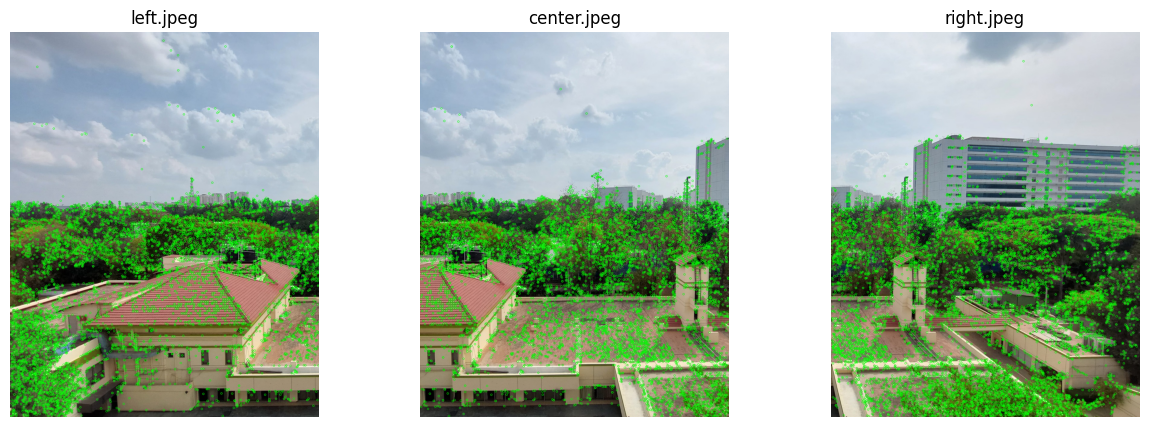

In [11]:
# Process each image and detect keypoints/descriptors
for path in image_paths:
    img, kps, des = detect_keypoints(path) # Detect keypoints and descriptors
    images.append(img)
    keypoints_list.append(kps)
    descriptors_list.append(des)

# Display images with keypoints
display_keypoints(images, keypoints_list, image_paths) # Display images with keypoints

### B

/var/folders/_6/8jyfdll53db96p9p5zrxqxhr0000gn/T/ipykernel_65711/353944106.py:56: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box) # Convert to integers


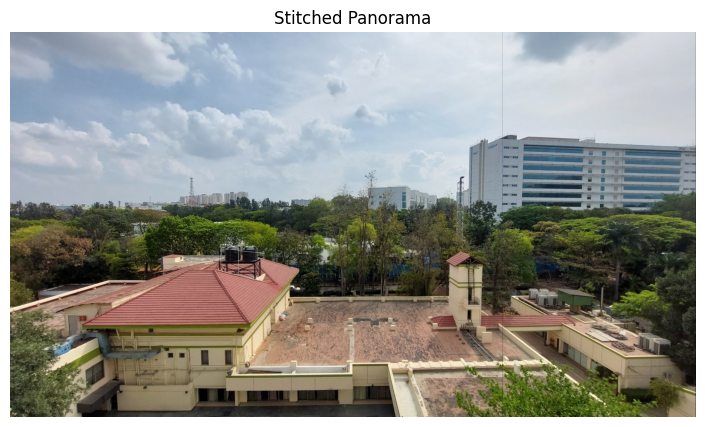

Stitched image shape: (1279, 2277, 3)


True

In [12]:
# Perform image stitching
stitched_image = stitch_images(images[0], images[1], keypoints_list[0],keypoints_list[1], descriptors_list[0], descriptors_list[1])

for i in range(1,len(images)):
    gr = cv2.cvtColor(stitched_image, cv2.COLOR_BGR2GRAY)
    kp, dsc = sift.detectAndCompute(gr, None) # Detect keypoints and descriptors
    stitched_image = stitch_images(stitched_image, images[i], kp, keypoints_list[i], dsc, descriptors_list[i]) # Stitch images
    stitched_image = crop_tilted_black_seam(stitched_image) # Crop tilted black seam

# Show the final stitched panorama
plt.figure(figsize=(15, 5))
plt.imshow(cv2.cvtColor(stitched_image, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Stitched Panorama")
plt.show()
print("Stitched image shape:", stitched_image.shape)

# Save the stitched panorama
cv2.imwrite("stitched_panorama1.jpg", stitched_image)